In [17]:
!pip install -q ucimlrepo xgboost lightgbm catboost scikit-learn matplotlib seaborn joblib

from ucimlrepo import fetch_ucirepo
import pandas as pd

# Загрузка датасета Statlog (Heart)
heart = fetch_ucirepo(id=145)

X = heart.data.features
y = heart.data.targets

# Преобразование и объединение
df = pd.concat([X, pd.Series(y.values.ravel(), name='target')], axis=1)

# По умолчанию в датасете целевые 1 и 2, а не 0 и 1. Переведем в 0 и 1 (по привычке)
df['target'] = df['target'].map({1: 0, 2: 1})

df.head()


,age,sex,chest-pain,rest-bp,serum-chol,fasting-blood-sugar,electrocardiographic,max-heart-rate,angina,oldpeak,slope,major-vessels,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0


In [18]:
print("Размер датасета:", df.shape)
print("\nПризнаки:\n", df.columns.tolist())
print("\nРаспределение целевой переменной:")
print(df["target"].value_counts())

# Проверка типов и пропусков
print("\nТипы данных:")
print(df.dtypes)

print("\nПропущенные значения:")
print(df.isnull().sum())


Размер датасета: (270, 14)

Признаки:
 ['age', 'sex', 'chest-pain', 'rest-bp', 'serum-chol', 'fasting-blood-sugar', 'electrocardiographic', 'max-heart-rate', 'angina', 'oldpeak', 'slope', 'major-vessels', 'thal', 'target']

Распределение целевой переменной:
target
0    150
1    120
Name: count, dtype: int64

Типы данных:
age                     float64
sex                     float64
chest-pain              float64
rest-bp                 float64
serum-chol              float64
fasting-blood-sugar     float64
electrocardiographic    float64
max-heart-rate          float64
angina                  float64
oldpeak                 float64
slope                   float64
major-vessels           float64
thal                    float64
target                    int64
dtype: object

Пропущенные значения:
age                     0
sex                     0
chest-pain              0
rest-bp                 0
serum-chol              0
fasting-blood-sugar     0
electrocardiographic    0
max-heart-

## Немножко еды

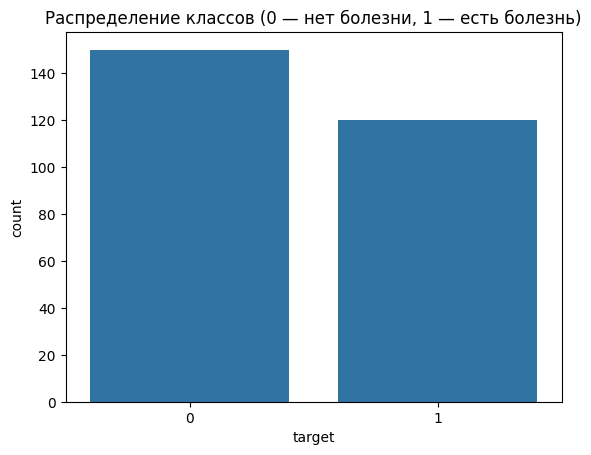

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Распределение по классам
sns.countplot(data=df, x="target")
plt.title("Распределение классов (0 — нет болезни, 1 — есть болезнь)")
plt.show()


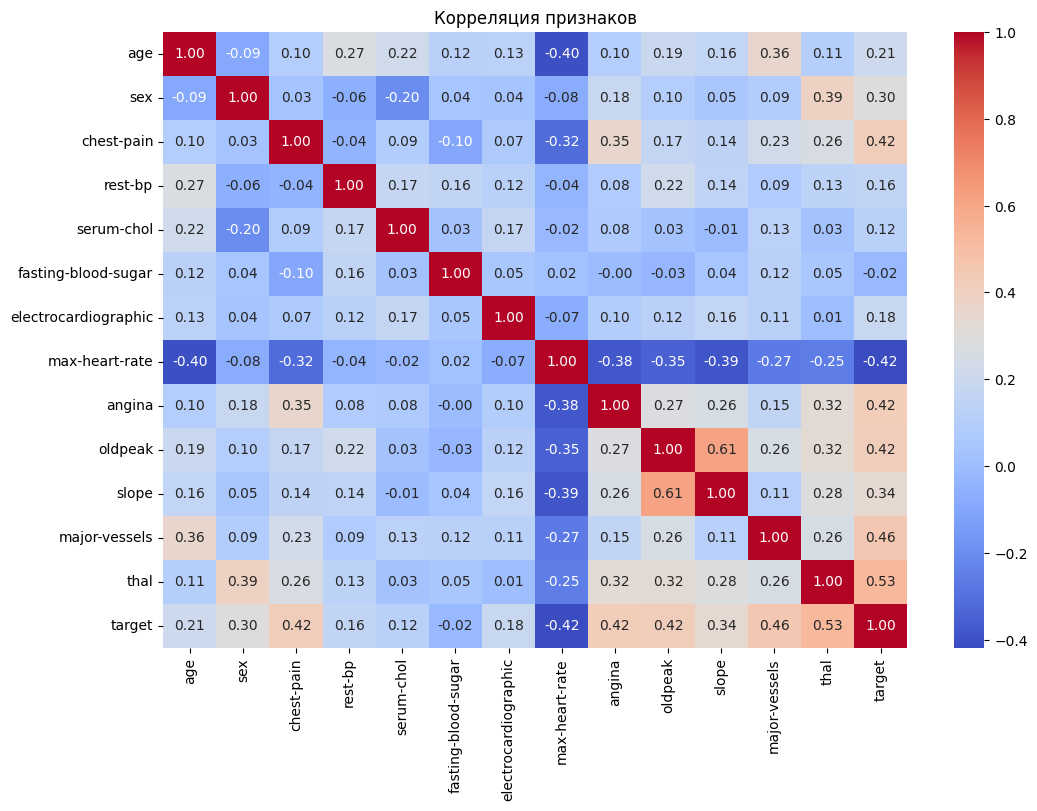

In [20]:
# Матрица корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция признаков")
plt.show()

# Что видно - целевой признак не со всеми хорошо скоррелирован, thal (Талассемия - наследственное заболевание крови)
# показывает хорошую корреляцию.

## Готовим данные

In [21]:
from sklearn.model_selection import train_test_split

X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (216, 13)
Test size: (54, 13)


## Настраиваем параметры модели и поиска по сетке

In [22]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve
import joblib

models = {
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'model__n_estimators': [100],
        'model__max_depth': [3, 4, 5],
    }),
    "LightGBM": (LGBMClassifier(), {
        'model__n_estimators': [100],
        'model__num_leaves': [16, 32, 64],
    }),
    "CatBoost": (CatBoostClassifier(verbose=0), {
        'model__iterations': [100],
        'model__depth': [4, 5, 6],
    }),
}

best_models = {}


## Обучаемся

In [23]:
for name, (clf, params) in models.items():
    print(f"\n{name} - GridSearchCV")

    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', clf)
    ])

    grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=5, verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_models[name] = best_model

    joblib.dump(best_model, f"{name}_best_model.pkl")

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    print("Best Params:", grid.best_params_)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cv_f1 = cross_val_score(best_model, X, y, cv=5, scoring='f1')
    print("CV F1 (mean ± std):", cv_f1.mean(), "±", cv_f1.std())



XGBoost - GridSearchCV


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:03:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:03:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:03:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:03:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'model__max_depth': 5, 'model__n_estimators': 100}
Accuracy: 0.8333333333333334
F1 Score: 0.8163265306122449
ROC AUC: 0.8694444444444445

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.80      0.83      0.82        24

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:03:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:03:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CV F1 (mean ± std): 0.7859903381642513 ± 0.06922083301175068

LightGBM - GridSearchCV
[LightGBM] [Info] Number of positive: 96, number of negative: 120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## Еееее РОК

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


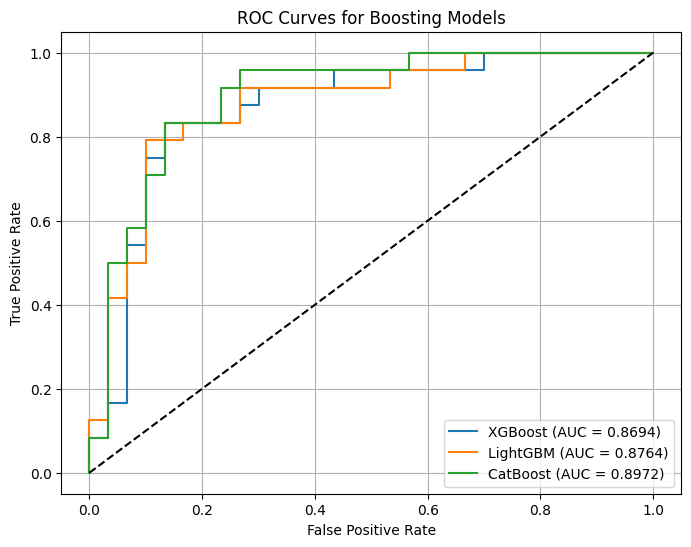

In [24]:
plt.figure(figsize=(8, 6))

for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Boosting Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [26]:
from sklearn.metrics import confusion_matrix

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name}:\n{cm}\n")


XGBoost:
[[25  5]
 [ 4 20]]

LightGBM:
[[25  5]
 [ 4 20]]

CatBoost:
[[25  5]
 [ 4 20]]



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [25]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Таблица метрик
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "ROC AUC": roc_auc
    })

# Создание и отображение DataFrame с результатами
metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.sort_values(by="F1 Score", ascending=False)
metrics_df.reset_index(drop=True, inplace=True)

metrics_df

# немного странно что все кроме roc auc идентично, но списываю на то что датасет слишком мал

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Accuracy,F1 Score,Precision,Recall (Sensitivity),Specificity,ROC AUC
0,XGBoost,0.833333,0.816327,0.8,0.833333,0.833333,0.869444
1,LightGBM,0.833333,0.816327,0.8,0.833333,0.833333,0.876389
2,CatBoost,0.833333,0.816327,0.8,0.833333,0.833333,0.897222


## Тестируем лучшую модельку

=== CatBoost Final Evaluation ===
Accuracy: 0.8333333333333334
F1 Score: 0.8163265306122449
Precision: 0.8
Recall: 0.8333333333333334
ROC AUC: 0.8972222222222221

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.80      0.83      0.82        24

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



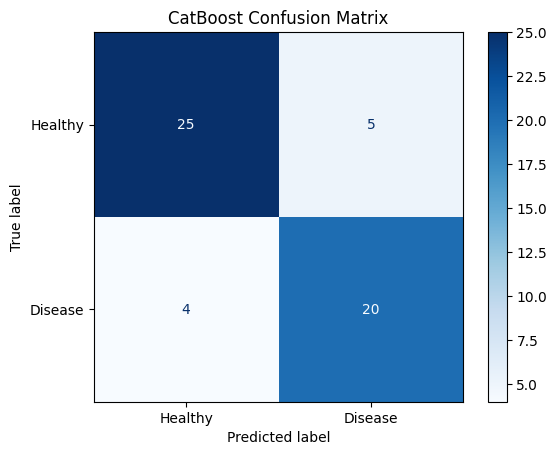

In [28]:
# Проверяем катбустовую модель
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = best_models["CatBoost"]

X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Предсказания
y_pred = model.predict(X_test_df)
y_proba = model.predict_proba(X_test_df)[:, 1]

# Метрики
print("=== CatBoost Final Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Disease"])
disp.plot(cmap="Blues")
plt.title("CatBoost Confusion Matrix")
plt.grid(False)
plt.show()

